# Lab CUDA Vision Project

Learning Vision Systems on Graphics Cards (MA-INF 4308)



## Import modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

## Imports
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm  # Import tqdm for progress visualization
from torch.cuda.amp import autocast, GradScaler
import os
import cv2
from PIL import Image



In [3]:

from src_revised.utils.augmentation import get_augmentations_normal
from src_revised.models.motion_encoder import MotionEncoder
from src_revised.models.depth_estimation import DepthEstimationModel
from src_revised.models.ego_estimation import EgoMotionModel
from src_revised.models.flow_estimation import OpticalFlowModel
from src_revised.utils.model_utils import load_checkpoint2
from src_revised.utils.visuals import *
from IPython.display import display, Image as IPImage
cwd = os.getcwd()
os.chdir(os.path.join(cwd,"src_revised"))
from src_revised.utils.notebook_utils import *

In [4]:
print("Module versions:")
print('\n'.join(f'{"> " + m.__name__}: {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
plt.style.use('seaborn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Module versions:
> cv2: 4.10.0
> PIL.Image: 10.3.0
> imageio: 2.34.1
> torch: 2.3.0+cu121
> numpy: 1.24.3


/tmp/ipykernel_1330151/290428926.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data Preparation and Preprocessing
- Organize the Dataset: Run city scripts.create_sequence.py on directory leftImg8bit_sequence
- Data Augmentation: Implement data augmentation techniques - (ColorJitter)
- Normalization: Normalize the image data to standardize the input distribution for better model convergence.
- Sequence Generation: Create pairs of consecutive frames for training.


## Data Loaders 


```py
train_dataset = CityscapesDataset(data_dir=train_data_path, transform=get_augmentations_normal)
val_dataset = CityscapesDataset(data_dir=val_data_path, transform=get_augmentations_normal)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
```

##  Model Architecture 
- Image Encoder (Convolutional Feature Extractor): ResNet18
- Motion Encoder: Adapted from MCDS-VSS. Concatenates the ht-1 and ht image features across channels to extract motion features
- Depth Decoder: Adapted from MCDS-VSS and MonoDepth2, uses the image features to estimate the depth map of the current frame. We use scaled disparity for the ego-warping.
- Ego-Motion Decoder: Adapted from MCDS-VSS a network head that predicts the camera's motion (ego-motion) between consecutive frames.
- Optical Flow Estimation: Create a separate network head that estimates the optical flow between consecutive frames.



In [5]:
resnet = models.resnet18(weights='IMAGENET1K_V1').to(device)
resnet = torch.nn.Sequential(*list(resnet.children())[:-2])
for param in resnet.parameters():
            param.requires_grad = False
motion_encoder = MotionEncoder(resnet=resnet).to(device)
depth_model = DepthEstimationModel(resnet=resnet).to(device)
ego_model = EgoMotionModel(MotionEncoder=motion_encoder).to(device)
flow_model = OpticalFlowModel(MotionEncoder=motion_encoder).to(device)

train.py can be used to train the model, vis_seq is a sample subsequence that will be used to create gifs at the end of each epoch. An example of creating vis_seq can be seen in Visualisation

```python
train_model(resnet, motion_encoder, depth_model, ego_model, flow_model, train_loader, val_loader, num_epochs=50, device=device, intrinsic_matrix=intrinsic_matrix, checkpoint_dir='/home/user/krishnanm0/project_checkpoints2', vis_seq=vis_seq)
```

In [6]:
optimizer_motion = torch.optim.Adam(motion_encoder.parameters(), lr=1e-4)
scheduler_motion = torch.optim.lr_scheduler.StepLR(optimizer_motion, step_size=10, gamma=0.1)
optimizer_depth = torch.optim.Adam(depth_model.parameters(), lr=1e-4)
scheduler_depth = torch.optim.lr_scheduler.StepLR(optimizer_depth, step_size=10, gamma=0.5)
motion_encoder, optimizer_motion, scheduler_motion, _, _ = load_checkpoint2(motion_encoder, optimizer_motion, scheduler_motion, "/home/user/krishnanm0/project_checkpoints3/motion_encoder_checkpoint_epoch_10.pth.tar")
ego_model = EgoMotionModel(MotionEncoder=motion_encoder).to(device)
flow_model = OpticalFlowModel(MotionEncoder=motion_encoder).to(device)
optimizer_ego = torch.optim.Adam(ego_model.decoder.parameters(), lr=1e-4)
scheduler_ego = torch.optim.lr_scheduler.StepLR(optimizer_ego, step_size=10, gamma=0.5)
optimizer_flow = torch.optim.Adam(flow_model.decoder.parameters(), lr=1e-4)
scheduler_flow = torch.optim.lr_scheduler.StepLR(optimizer_flow, step_size=10, gamma=0.5)
depth_model, optimizer_depth, scheduler_depth, _, _ = load_checkpoint2(depth_model, optimizer_depth, scheduler_depth, "/home/user/krishnanm0/project_checkpoints3/depth_model_checkpoint_epoch_10.pth.tar")
ego_model, optimizer_ego, scheduler_ego, _, _ = load_checkpoint2(ego_model, optimizer_ego, scheduler_ego, "/home/user/krishnanm0/project_checkpoints3/ego_model_checkpoint_epoch_10.pth.tar")
flow_model, optimizer_flow, scheduler_flow, _, _ = load_checkpoint2(flow_model, optimizer_flow, scheduler_flow, "/home/user/krishnanm0/project_checkpoints3/flow_model_checkpoint_epoch_10.pth.tar")

Checkpoint for motion_encoder_checkpoint_epoch_10.pth.tar loaded. Resuming from epoch 10 with loss 2854.7790.
Checkpoint for depth_model_checkpoint_epoch_10.pth.tar loaded. Resuming from epoch 10 with loss 2854.7790.
Checkpoint for ego_model_checkpoint_epoch_10.pth.tar loaded. Resuming from epoch 10 with loss 2854.7790.
Checkpoint for flow_model_checkpoint_epoch_10.pth.tar loaded. Resuming from epoch 10 with loss 2854.7790.


## Visualisation

Set path to the image sequence here for visualisation

In [7]:
visulize_sequence_path = "/home/user/krishnanm0/data/cityscape/val/lindau_000000"

In [8]:
vis_seqpath = []
frames = sorted(os.listdir(visulize_sequence_path))
for i in range(len(frames) - 1):
    vis_seqpath.append(os.path.join(visulize_sequence_path, frames[i]))
vis_seq = []
for path in vis_seqpath:
    # Load the images
    frame1 = Image.open(path)
    # Apply any preprocessing or augmentation
    transform = get_augmentations_normal()
    if transform:
        frame1 = transform(frame1)
    vis_seq.append(frame1.to(device).unsqueeze(0))

Optical Flow Gif [Flow Map - Full Flow - Original Frame]
Optical Flow GIF saved at flow_animation.gif


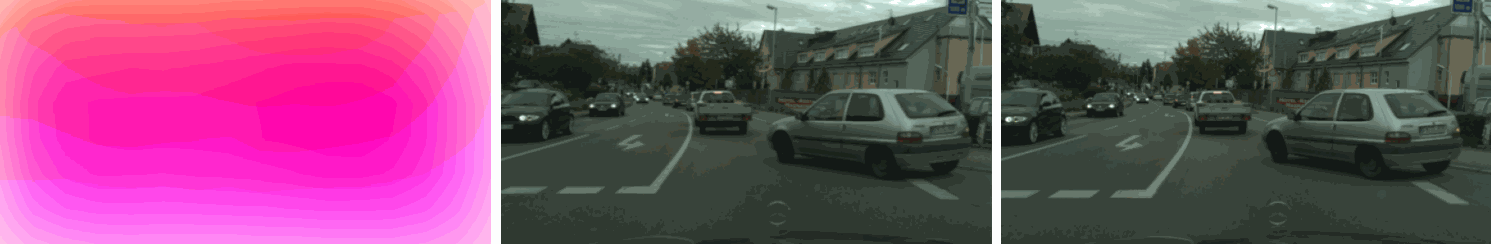

Depth and Ego Estimation Gif [Depth Map - Rigid Flow - Original Frame]
Depth-Ego Estimation GIF saved at depth_animation.gif


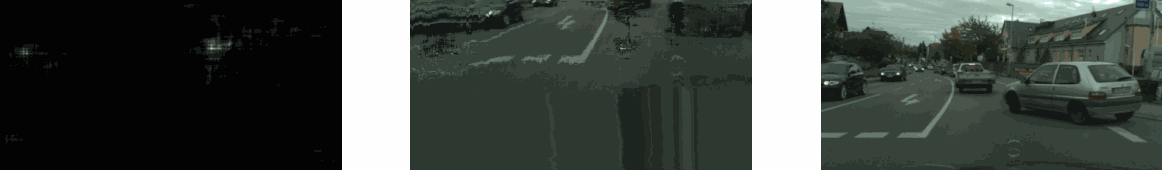

In [9]:
create_gif(depth_model,flow_model,ego_model,vis_seq)